# Applied Data Science Capstone Project

Welcome to my __Capstone Project__.  
I tried to build this __notebook__ in a way that it is as straightforward as possible to go through, just scroll down, read the __markdown__ comments and look at the images and graphics.  
Of course there's a PDF report with all the details and explanations.

In [252]:
import requests
import unicodedata
from bs4 import BeautifulSoup
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

### Getting the data

I start by reading a CSV file that I downloaded from https://simplemaps.com/data/world-cities with thousands of world cities.  
I then filter it to get just the capitals.  
  
_The next line is hidden because it has my IBM Cloud credentials._  


In [253]:
# The code was removed by Watson Studio for sharing.

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [254]:
df_data_0.shape

(15493, 11)

In [255]:
capitals = df_data_0[df_data_0['capital'] == 'primary']

In [256]:
capitals = capitals[["city_ascii","lat","lng","country"]]
capitals.rename(columns={"city_ascii": "Capital", "country": "Country"}, inplace = True)
capitals.head()

,Capital,lat,lng,Country
0,Tokyo,35.6850,139.7514,Japan
2,Mexico City,19.4424,-99.1310,Mexico
9,Dhaka,23.7231,90.4086,Bangladesh
10,Buenos Aires,-34.6025,-58.3975,Argentina
12,Cairo,30.0500,31.2500,Egypt


In [257]:
capitals.shape

(212, 4)

__Scrape Capital's population from Wikipedia__  
I had to get the population from Wikipedia because some of the values in the CSV file are just way off.  
  
_I created a couple of functions to parse the name of the Capitals and the population value due to some special characters, references and annotations_

In [258]:
def ParsePopulation(x):
    s=""
    for c in x:
        if not(c.isdigit()) and c!=',' and c!=' ':
            return s
        if c.isdigit():
            s=s+c
    return s

def ParseCapitals(s):
    a =''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')
    s=""
    for c in a:
        if c==',' or c=='(' or c=='[':
            return s.strip()
        s=s+c
    return s.strip()

In [259]:
res = requests.get('https://en.wikipedia.org/wiki/List_of_national_capitals_by_population')
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[1]
wiki = pd.read_html(np.str(table))[0][['Capital','Population']]
wiki['Capital'] = [ParseCapitals(s) for s in wiki['Capital']]
wiki['Population'] = [ParsePopulation(s) for s in wiki['Population']]
wiki.head()

,Capital,Population
0,Beijing,21542000
1,Tokyo,13929286
2,Moscow,12506468
3,Kinshasa,11855000
4,Jakarta,10075310


In [260]:
wiki.shape

(244, 2)

__Merge the tables and ignore rows without values__  
_We're losing some rows due mostly to geopolitics and the likes._

In [261]:
capitals = capitals.merge(wiki,how='left').dropna()

In [262]:
capitals.shape

(189, 5)

### Mapping the Capitals

Let's show the Capitals on a World Map, with colors ranging from yellow to red and increased radius as the population increases.


In [263]:
# create World map
world_map = folium.Map(location=[0, 0], zoom_start=2)
rainbow = [colors.rgb2hex(i) for i in [[1,1-i/9,0,1] for i in range(10)]]

# add markers to map
for lat, lng, city, country, population in zip(capitals['lat'], capitals['lng'], capitals['Capital'], capitals['Country'], capitals['Population']):
    label = '{}, {} ({})'.format(city, country, population)
    label = folium.Popup(label, parse_html=True)
    popinM=int(population)/1000000
    radius=popinM
    if popinM>9:
        radius=9
        popinM=9
    elif popinM<3:
        radius=3
    folium.CircleMarker(
        [lat, lng],
        radius=radius,
        popup=label,
        color=rainbow[int(popinM)],
        fill=True,
        fill_color=rainbow[int(popinM)],
        fill_opacity=1,
        parse_html=False).add_to(world_map)

world_map

### Get the venues

Let's get the venues in the vicinity of the Capitals.  
The radius will depend on the population, the value will start at 5000 meters and then 500m will be added for each 1M of population.  
  
_The next line is hidden because it has my Foursquare credentials._  

In [264]:
# The code was removed by Watson Studio for sharing.

In [265]:
def getNearbyVenues(names, latitudes, longitudes, population):
    
    venues_list=[]
    for name, lat, lng, pop in zip(names, latitudes, longitudes, population):
        # radius will be 5k plus 500m for each 1M of population
        radius=int(5000 + 500*int(pop)/1000000)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request resilient to empty answers (retries)
        json = ""
        while json == "":
            json = requests.get(url).json()
        results = json["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital', 
                  'Venue', 
                  'lat', 
                  'lng', 
                  'Category']
    
    return(nearby_venues)

In [266]:
#capital_venues = getNearbyVenues(names=capitals['Capital'], latitudes=capitals['lat'], longitudes=capitals['lng'], population=capitals['Population'])
# NOTE: I saved the data into a file to speed up the analysis
body = client_0c31be0f9bf64d83a55f64b70d957170.get_object(Bucket='anotherproject-donotdelete-pr-z0nrxm0tpqnbl1',Key='capital_venues.csv')['Body']
capital_venues = pd.read_csv(body)
capital_venues.shape

(13253, 6)

In [267]:
print('There are {} unique categories.'.format(len(capital_venues['Category'].unique())))
capital_venues.sample(20)

There are 503 unique categories.


,Unnamed: 0,Capital,Venue,lat,lng,Category
11758,11758,Nicosia,GymPro,35.164388,33.348339,Gym
6891,6891,Sofia,Salted Cafe,42.699677,23.317465,Vegetarian / Vegan Restaurant
2796,2796,Berlin,Zeit für Brot,52.530394,13.401852,Bakery
4270,4270,Accra,Venus bar,5.565305,-0.182026,Bar
1553,1553,Taipei,南村小吃,25.028760,121.567562,Chinese Restaurant
6738,6738,Stockholm,Zita,59.338449,18.068376,Movie Theater
2507,2507,Hanoi,The Hanoi Social Club,21.029003,105.846026,Café
1866,1866,Madrid,Yoka Loka,40.411615,-3.698693,Sushi Restaurant
3077,3077,Kabul,Blue Flame,34.504551,69.136452,Italian Restaurant
1429,1429,Kinshasa,Le Palais,-4.329076,15.272966,Restaurant


### High level analysis  
Let's do some simple plotting of categories per Capital, also Capitals per category and a scatter plot of both to understand what we are working with.  

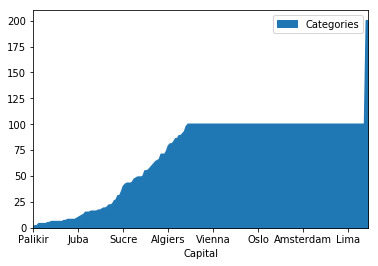

In [269]:
categoriespercapital = capital_venues[['Capital']]
categoriespercapital.loc[:,'Categories'] = 1
categoriespercapital = categoriespercapital.groupby('Capital').count().sort_values('Categories')
categoriespercapital.plot.area(y='Categories')

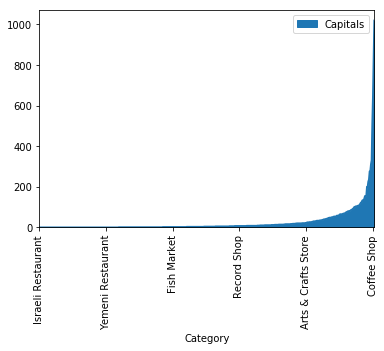

In [270]:
capitalspercategory = capital_venues[['Category']]
capitalspercategory.loc[:,'Capitals'] = 1
capitalspercategory = capitalspercategory.groupby('Category').count().sort_values('Capitals')
capitalspercategory.plot.area(y='Capitals',rot = 90)

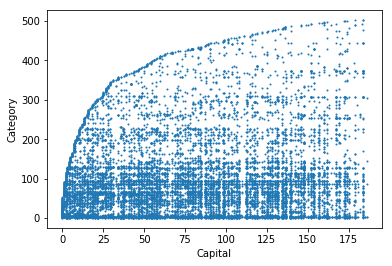

In [272]:
capitalvscategory = capital_venues[['Capital','Category']]
capitalvscategory.loc[:,'Capital'] = pd.factorize(capitalvscategory['Capital'])[0]
capitalvscategory.loc[:,'Category'] = pd.factorize(capitalvscategory['Category'])[0]
capitalvscategory.plot.scatter(x='Capital',y='Category',s=1)

### Calculate the frequency of each category per Capital

One-hot enconding and averaging

In [273]:
# one hot encoding
onehot = pd.get_dummies(capital_venues['Category'], prefix="", prefix_sep="")
onehot['Capital'] = capital_venues['Capital'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

# group rows by Capital and by taking the mean of the frequency of occurrence of each category
grouped = onehot.groupby('Capital').mean().reset_index()

### Create the clusters

Group the Capitals based on the frequencies of the categories using the K-Means algorithm, and get histograms for 2 to 10 clusters.  

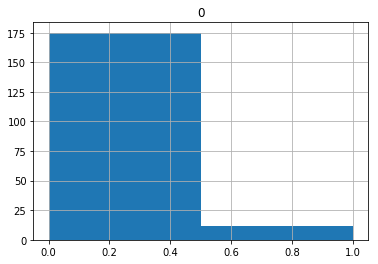

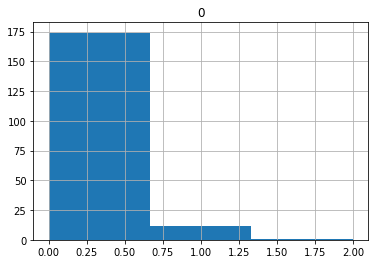

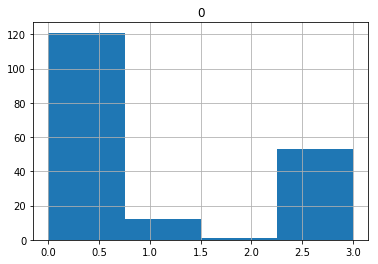

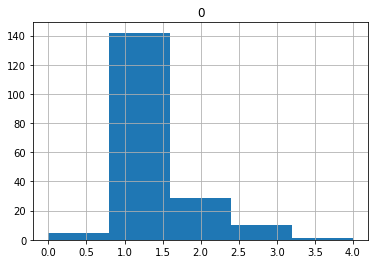

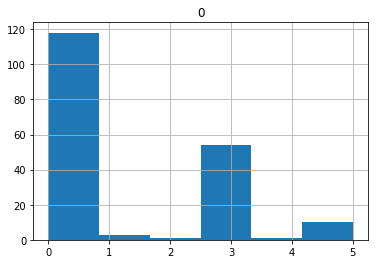

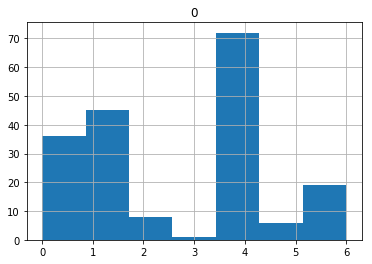

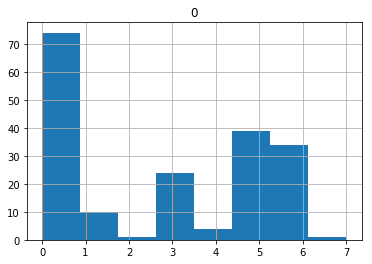

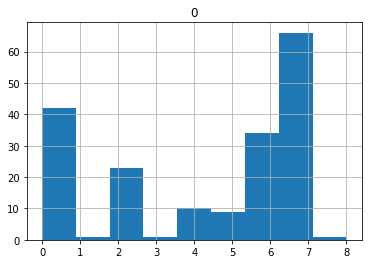

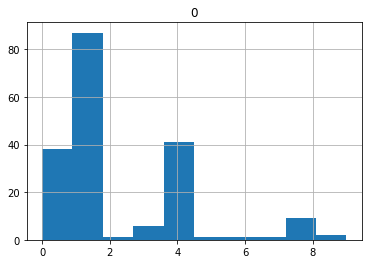

In [274]:
def dokmeans(kclusters):
    grouped_clustering = grouped.drop('Capital', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

    groups = pd.DataFrame(kmeans.labels_)
    groups.hist(bins=kclusters)

# test for multiple cluster sizes
for kclusters in range(2,11):
    dokmeans(kclusters)


### Map the "best" set of clusters

Let's choose one set and map the result 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8112be2a58>]],
      dtype=object)

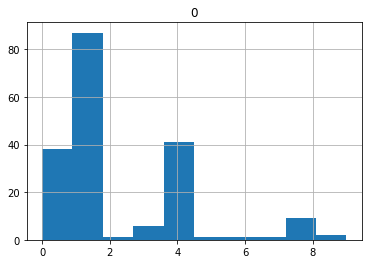

In [275]:
bestk = 10
grouped_clustering = grouped.drop('Capital', 1)
kmeans = KMeans(n_clusters=bestk, random_state=0).fit(grouped_clustering)
final = grouped[['Capital']]
final.insert(0, 'Cluster', kmeans.labels_)
merged = final.merge(capitals, how = 'left')
groups = pd.DataFrame(kmeans.labels_)
groups.hist(bins=bestk)

In [276]:
# create World map
world_map = folium.Map(location=[0, 0], zoom_start=2)
rainbow = ['#ff0000ff','#00ff00ff','#0000ffff','#ffff00ff','#ff00ffff','#00ffffff','#ffffffff','#000000ff','#9999ffff','#ff9999ff' ]

# add markers to map
for lat, lng, city, country, cluster in zip(merged['lat'], merged['lng'], merged['Capital'], merged['Country'], merged['Cluster']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1,
        parse_html=False).add_to(world_map)

world_map

### What are the most frequent categories?

Let's lists the top ten most frequent categories per cluster

In [277]:
final_clustering = pd.DataFrame(grouped_clustering,copy=True)
final_clustering.insert(0, 'Cluster', kmeans.labels_)
final_clustering = final_clustering.groupby('Cluster').sum().reset_index()

In [278]:
def top_ten_categories(row):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:10]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
clusters_sorted = pd.DataFrame(columns=columns)
clusters_sorted['Cluster'] = final_clustering['Cluster']

for ind in np.arange(final_clustering.shape[0]):
    clusters_sorted.iloc[ind, 1:] = top_ten_categories(final_clustering.iloc[ind, :])

clusters_sorted

,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,0,Hotel,Restaurant,Café,Shopping Mall,Pizza Place,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Grocery Store,Bar
1,1,Hotel,Coffee Shop,Café,Restaurant,Bar,Park,Bakery,Italian Restaurant,Plaza,Ice Cream Shop
2,2,Hotel,Zoo,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
3,3,Hotel,Resort,Airport,French Restaurant,African Restaurant,Hotel Pool,Café,Museum,Lake,Irish Pub
4,4,Café,Hotel,Coffee Shop,Restaurant,Italian Restaurant,Bar,Pizza Place,Bakery,Park,Plaza
5,5,Dive Shop,Zoo,Fish & Chips Shop,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
6,6,Harbor / Marina,Hotel,River,Clothing Store,Nature Preserve,Fabric Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
7,7,Beach,Hotel,Zoo,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
8,8,Hotel,Café,Bar,Plaza,Hotel Bar,National Park,Brewery,Restaurant,Movie Theater,Noodle House
9,9,Shopping Mall,Hotel,Restaurant,Border Crossing,Gas Station,Café,Supermarket,Pub,Hotel Bar,Indian Restaurant
